# Mi año en Spotify

Este notebook esta inspirado en el [blog de Nerudista en tacos de datos](https://tacosdedatos.com/dueno-de-mis-datos-spotify "Dueño de mis datos") y en el [blog de Antonio Feregrino tambien en tacos de datos](https://tacosdedatos.com/mas-data-viz-con-spotify-python) que nos propone poder visualizar nuestra actividad en Spotify como la de GitHub.

La idea de replicarlo nacio de un reto que le hice a [Stanley Salvatierra](https://twitter.com/iamatachyon). Al final el gano, pues yo tengo la mala costumbre de dejar las cosas a media y no terminarlas hasta, pero espero emepzar a cambiar ese habito con este notebook.

### Exploracion de los datos
Lo primero que haremos sera obtener los datos de Spotify, para ello es necesario ingresar a tu cuenta de Spotify y [solicitarlos](https://www.spotify.com/mx/account/privacy/) demora un poco pero no sera ams de 1 semana.

Una vez que ya tienes tus datos en tu pequeño .zip debes buscar los archivos JSON **"StreamingHistoryXX.json"** que son los que contiene tu informacion de Stearming __¿Que locura no?__

Vamos a importar las herramientas que nos ayudaran en el preprocesamiento y visualizacion, pues el **JSON** sufrira algunos cambios.

In [48]:
from glob import glob
import json
import pandas as pd
import calendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

Con esta funcion vamos a leer los datos del o de los **.json**

In [59]:
def read_history():
    history = []
    for file in sorted(glob("StreamingHistory*.json")):
        with open(file, 'rb')as readable:
            history.extend(json.load(readable,))
    history = pd.DataFrame(history)
    history["endTime"] = pd.to_datetime(history["endTime"])
    return history

Ejecutamos la funcion y visualizamos nuestros datos

In [60]:
streaming_history = read_history()
streaming_history.head(5)

,endTime,artistName,trackName,msPlayed
0,2019-03-06 01:12:00,Sebastian Yatra,Ya No Tiene Novio,48320
1,2019-03-07 18:30:00,Sebastian Yatra,Ya No Tiene Novio,1331
2,2019-03-07 18:34:00,Leslie Odom Jr.,Alexander Hamilton,236737
3,2019-03-07 18:36:00,Lin-Manuel Miranda,"Aaron Burr, Sir",156630
4,2019-03-07 18:42:00,Lin-Manuel Miranda,My Shot,333154


Vamos a personalizar el DataFrame, pues solo necesitamos la fecha en la que escuchamos la cancion y realizar algunas transformaciones numericas de los dias y las semanas

In [30]:
streaming_history["date"] = streaming_history["endTime"].dt.floor('d')

In [31]:
by_date = streaming_history.groupby("date")[["trackName"]].count()
by_date = by_date.sort_index()

In [61]:
by_date["weekday"] = by_date.index.weekday
by_date["week"] = by_date.index.week

Y este seria el resultado final de nuestro DataFrame, depsues de agrupar por fecha las canciones que escuchamos

In [62]:
by_date.head(5)

,trackName,weekday,week,continuous_week
date,,,,
2019-03-06,1,2,10,0
2019-03-07,42,3,10,0
2019-03-11,3,0,11,1
2019-03-12,14,1,11,1
2019-03-13,103,2,11,1


Lo que nos falta es transformar las semanas para iniciar en 0 nuestro grafico

In [39]:
week = 0
prev_week = by_date.iloc[0]["week"]
continuous_week = np.zeros(len(by_date)).astype(int)
sunday_dates = []
for i, (_, row) in enumerate(by_date.iterrows()):
    if row["week"] != prev_week:
        week += 1
        prev_week = row["week"]
    continuous_week[i] = week
by_date["continuous_week"] = continuous_week 
by_date.head()

,trackName,weekday,week,continuous_week
date,,,,
2019-03-06,1,2,10,0
2019-03-07,42,3,10,0
2019-03-11,3,0,11,1
2019-03-12,14,1,11,1
2019-03-13,103,2,11,1


Y ahora preparamos la matriz de dias x canciones, donde cada dia de la semana tendremos el numero de canciones que hemos escuchado.

In [41]:
songs = np.full((7, continuous_week.max()+1), np.nan)

for index, row in by_date.iterrows():
    songs[row["weekday"]][row["continuous_week"]] = row["trackName"]

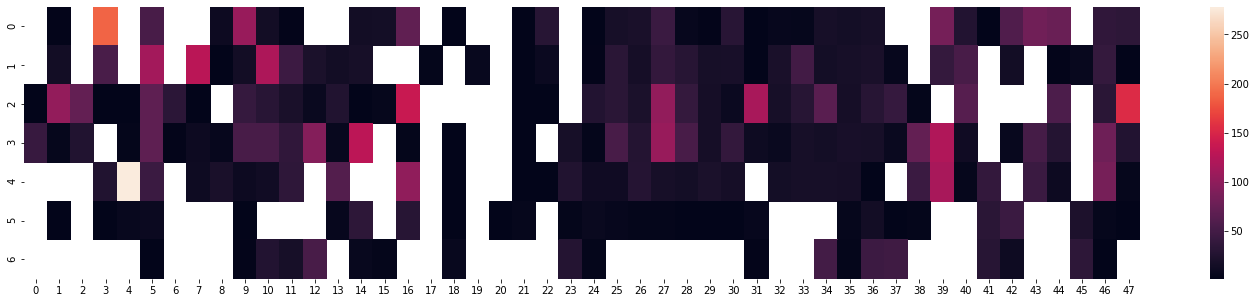

In [64]:
fig = plt.figure(figsize=(25,5))
ax = plt.subplot()
mask = np.isnan(songs)
sns.heatmap(songs, ax = ax)

El resultado del primer grafico no queda muy bonito, pero estamos muy cerca del objetivo, solo tenemos que hacer unos cuantos cambios. 

Vamos a modificar las etiquetas de los ejes, el eje X es calculado por la ifnromacion que tienemos. 
- Primero, obtenemos la fecha minima de lista de nuestras caciones, en mi caso _2019-03-06 01:12:00_
- Segundo, vamos a calcular el primer lunes mas cercano a nuestra fecha minima, en mi caso _2019-03-04 01:12:00_
- Tercero, calculamos un Array de todos los lunes hasta la ultima semana que tenemos en canciones.
- Cuarto, obtenemos los meses y el numero de semanas por mes para las cabeceras donde la primera semana tendra el nombre del mes

Para el eje Y la modificacion es mucho mas simple, solo se listan los dias

In [78]:
min_date = streaming_history["endTime"].min()
print(min_date)
first_monday = min_date - timedelta(min_date.weekday())
print(first_monday)
mons = [first_monday + timedelta(weeks=wk) for wk in range(continuous_week.max())]
x_labels = [calendar.month_abbr[mons[0].month]]
x_labels.extend([
    calendar.month_abbr[mons[i].month] if mons[i-1].month != mons[i].month else "" 
    for i in range(1, len(mons))])
print(x_labels)
y_labels = ["Mon", "", "Wed", "", "Fri", "", "Sun"]

2019-03-06 01:12:00
2019-03-04 01:12:00
['Mar', '', '', '', 'Apr', '', '', '', '', 'May', '', '', '', 'Jun', '', '', '', 'Jul', '', '', '', '', 'Aug', '', '', '', 'Sep', '', '', '', '', 'Oct', '', '', '', 'Nov', '', '', '', 'Dec', '', '', '', '', 'Jan', '', '']


Finalmente vamos a modificar la cabecera, el color, el tamaño de la fuente, el tamaño del grafico. 

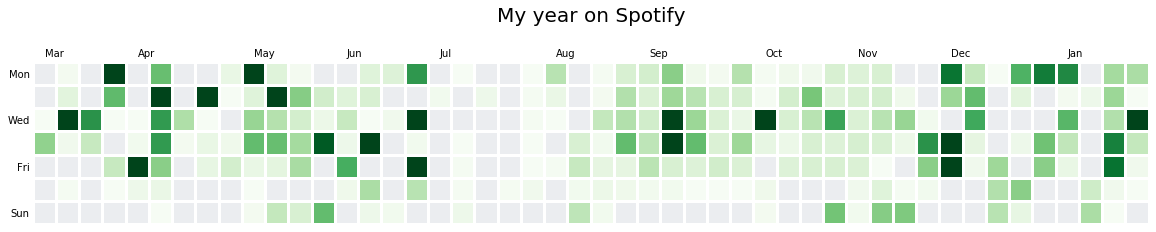

In [58]:
fig = plt.figure(figsize=(20,5))
ax = plt.subplot()

ax.set_title("Mi año en Spotify", fontsize=20,pad=40)
ax.xaxis.tick_top()
ax.tick_params(axis='both', which='both',length=0)
ax.set_facecolor("#ebedf0") 
fig.patch.set_facecolor('white')
sns.heatmap(songs, linewidths=2, linecolor='white', square=True,
            mask=np.isnan(songs), cmap="Greens",
            vmin=0, vmax=100, cbar=False, ax=ax)

ax.set_yticklabels(y_labels, rotation=0)
ax.set_xticklabels(x_labels, ha="left")
pass